In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import patsy
from sklearn import preprocessing
import seaborn as sns

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sns.set_style('ticks')
sns.set_palette("deep")

In [3]:
# the following function is copied from https://github.com/Teichlab/NaiveDE/blob/master/NaiveDE/base.py
# it is a python implementation of limma's removeBatchEffect function
# many thanks to Valentine Svensson (https://github.com/vals)

def regress_out(sample_info, expression_matrix, covariate_formula, design_formula='1', rcond=-1):
    # Ensure intercept is not part of covariates
    covariate_formula += ' - 1'

    covariate_matrix = patsy.dmatrix(covariate_formula, sample_info)
    design_matrix = patsy.dmatrix(design_formula, sample_info)

    design_batch = np.hstack((design_matrix, covariate_matrix))

    coefficients, res, rank, s = np.linalg.lstsq(design_batch, expression_matrix.T, rcond=rcond)
    beta = coefficients[design_matrix.shape[1]:]
    regressed = expression_matrix - covariate_matrix.dot(beta).T

    return regressed

In [4]:
jaenisch = pd.read_csv('PRJNA326944_rna_seq_count.csv', index_col=0)
liu_hepsc = pd.read_csv('hepsc_bulk_rna_seq_count.csv', index_col=0)
liu_pepsc = pd.read_csv('pepsc_bulk_rna_seq_count.csv', index_col=0)
liu_mepsc = pd.read_csv('mepsc_bulk_rna_seq_count.csv', index_col=0)

In [5]:
# take the orthologs table and only keep one-to-one orthologs

hp_orthologs = pd.read_table("human_pig_homologs.tsv")
hp_orthologs = hp_orthologs[hp_orthologs["Pig homology type"] == "ortholog_one2one"]
hm_orthologs = pd.read_table("human_mouse_homologs.tsv")
hm_orthologs = hm_orthologs[hm_orthologs["Mouse homology type"] == "ortholog_one2one"]

In [6]:
# merge human_mouse and human_pig othologs table into one

hm_orthologs.index = hm_orthologs["Gene stable ID"]
hp_orthologs.index = hp_orthologs["Gene stable ID"]
hmp = pd.concat([hm_orthologs, hp_orthologs], axis=1, join="inner")
hmp = hmp.iloc[:,1:]
hmp.head(2)

,Gene name,Mouse gene stable ID,Mouse gene name,Mouse homology type,Gene stable ID,Gene name,Pig gene stable ID,Pig gene name,Pig homology type
Gene stable ID,,,,,,,,,
ENSG00000275994,SNORA24,ENSMUSG00000077360,Gm23482,ortholog_one2one,ENSG00000275994,SNORA24,ENSSSCG00000018373,SNORA24,ortholog_one2one
ENSG00000277994,HOTAIR_3,ENSMUSG00000098572,Gm27443,ortholog_one2one,ENSG00000277994,HOTAIR_3,ENSSSCG00000032179,HOTAIR_3,ortholog_one2one


In [7]:
# change mouse and pig gene IDs to human gene IDs

rename_pig = dict(hmp.loc[:,["Pig gene stable ID", "Gene stable ID"]].values)
rename_mus = dict(hmp.loc[:,["Mouse gene stable ID", "Gene stable ID"]].values)
liu_pepsc.rename(index=rename_pig, inplace=True)
liu_mepsc.rename(index=rename_mus, inplace=True)

In [8]:
count_matrix = pd.concat([jaenisch, liu_hepsc, liu_pepsc, liu_mepsc], axis=1, join="inner")
count_matrix.shape

(14692, 22)

In [9]:
count_matrix.head(2)

,Male_Primed_WIBR1,Naive_WIBR3_cl_12,Naive_WIBR2,Naive_WIN1_2,Male_Primed_iPS_NPC_4,Naive_WIBR3_cl_16,Male_Primed_iPS_NPC_13,Naive_WIN1_1,H1_EPSC_1,H1_EPSC_2,...,piPSC_EPSC_2,PEF_1,piPSC_EPSC_1,pParEPSC_2,pParEPSC_1,pEPSC_1,pEPSC_2,PEF_2,E14_EPSCM,AB2_EPSCM
ENSG00000198727,69078,132524,90166,70905,60042,149997,51833,113285,13588,11664,...,138838,52098,106833,224951,134107,133326,113783,47345,51219,14699
ENSG00000198695,38468,78074,65191,25858,38569,72817,28372,38394,3797,3008,...,60379,65213,37625,76909,53543,50014,41423,67025,11599,3222


In [10]:
sample_info = pd.DataFrame(index=count_matrix.columns)
sample_info["total_count"] = count_matrix.sum()
sample_info["species"] = ["human"] * 12 + ["pig"] * 8 + ["mouse"] * 2
sample_info["batch"] = ["jaenisch"] * 8 + ["liu1"] * 4 + ["liu2"] * 8 + ["liu3"] * 2
sample_info["state"] = sample_info.index.str.extract("(.*)_.*", expand=False)
human_naive = sample_info.index[sample_info.index.str.contains("Naive")]
human_prime = sample_info.index[sample_info.index.str.contains("Primed")]
sample_info.loc[human_naive, "state"] = "Jaenisch_naive"
sample_info.loc[human_prime, "state"] = "Jaenisch_prime"
sample_info.loc["E14_EPSCM", "state"] = "E14_EPSC"
sample_info.loc["AB2_EPSCM", "state"] = "AB2_EPSC"
sample_info

,total_count,species,batch,state
Male_Primed_WIBR1,22017520,human,jaenisch,Jaenisch_prime
Naive_WIBR3_cl_12,33511407,human,jaenisch,Jaenisch_naive
Naive_WIBR2,41690872,human,jaenisch,Jaenisch_naive
Naive_WIN1_2,20897303,human,jaenisch,Jaenisch_naive
Male_Primed_iPS_NPC_4,21876451,human,jaenisch,Jaenisch_prime
Naive_WIBR3_cl_16,32627907,human,jaenisch,Jaenisch_naive
Male_Primed_iPS_NPC_13,22625015,human,jaenisch,Jaenisch_prime
Naive_WIN1_1,25411851,human,jaenisch,Jaenisch_naive
H1_EPSC_1,12076062,human,liu1,H1_EPSC
H1_EPSC_2,12479011,human,liu1,H1_EPSC


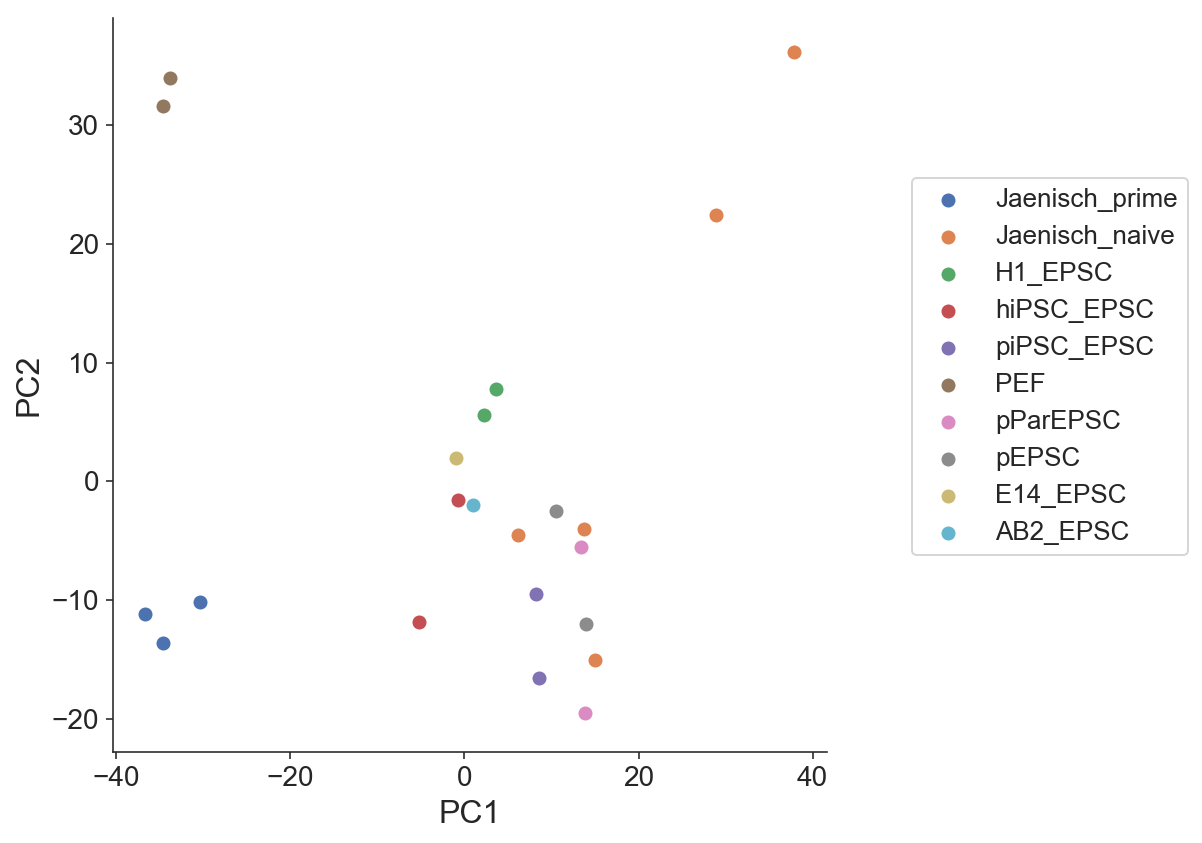

In [11]:
logexp = np.log10(count_matrix + 1)
res = regress_out(sample_info, logexp, "batch + np.log10(total_count)", rcond=1e-4)

scaled = preprocessing.scale(res.T, axis=1, with_std=False)

pca = PCA(n_components=2)
pca.fit(scaled)
reduced = pca.transform(scaled)

sample_info["PC1"] = reduced[:,0]
sample_info["PC2"] = reduced[:,1]

g = sns.FacetGrid(sample_info, hue='state', height=6)
g.map(plt.scatter, "PC1", "PC2")
# g.ax.set_xscale('log')
g.ax.legend(bbox_to_anchor=[1.1, 0.8])
# plt.savefig("figs/pca_cross_species_jaenisch_ds.pdf", bbox_inches="tight", transparent=True)
plt.show()

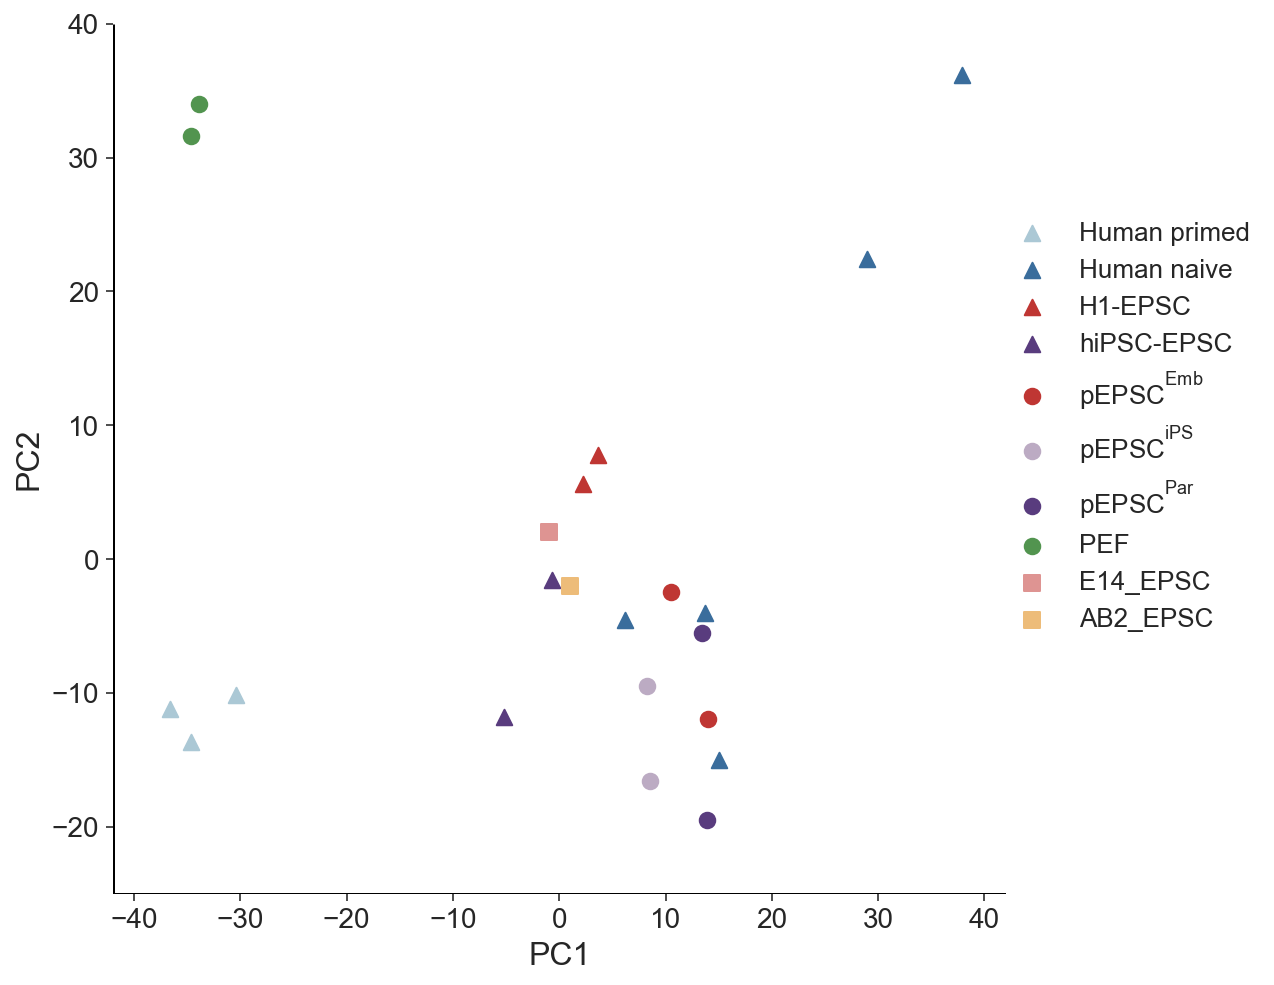

In [12]:
plt.figure(figsize=(8,8))
# primed
plt.scatter(sample_info.query('state == "Jaenisch_prime"')['PC1'],
            sample_info.query('state == "Jaenisch_prime"')['PC2'],
            c='#abc8d5', marker='^', s=60, label='Human primed')
# naive
plt.scatter(sample_info.query('state == "Jaenisch_naive"')['PC1'],
            sample_info.query('state == "Jaenisch_naive"')['PC2'],
            c='#3a6d9c', marker='^', s=60, label='Human naive')
# H1-EPSC
plt.scatter(sample_info.query('state == "H1_EPSC"')['PC1'],
            sample_info.query('state == "H1_EPSC"')['PC2'],
            c='#bf3633', marker='^', s=60, label='H1-EPSC')
# hiPSC-EPSC
plt.scatter(sample_info.query('state == "hiPSC_EPSC"')['PC1'],
            sample_info.query('state == "hiPSC_EPSC"')['PC2'],
            c='#593c7e', marker='^', s=60, label='hiPSC-EPSC')
# pEPSC-emb
plt.scatter(sample_info.query('state == "pEPSC"')['PC1'],
            sample_info.query('state == "pEPSC"')['PC2'],
            c='#bf3633', marker='o', s=60, label=r'$pEPSC^{Emb}$')
# pEPSC-ipsc
plt.scatter(sample_info.query('state == "piPSC_EPSC"')['PC1'],
            sample_info.query('state == "piPSC_EPSC"')['PC2'],
            c='#bcabc3', marker='o', s=60, label=r'$pEPSC^{iPS}$')
# pEPSC-par
plt.scatter(sample_info.query('state == "pParEPSC"')['PC1'],
            sample_info.query('state == "pParEPSC"')['PC2'],
            c='#593c7e', marker='o', s=60, label=r'$pEPSC^{Par}$')
# pEF
plt.scatter(sample_info.query('state == "PEF"')['PC1'],
            sample_info.query('state == "PEF"')['PC2'],
            c='#52944f', marker='o', s=60, label='PEF')
# E14
plt.scatter(sample_info.query('state == "E14_EPSC"')['PC1'],
            sample_info.query('state == "E14_EPSC"')['PC2'],
            c='#de9492', marker='s', s=60, label='E14_EPSC')
# AB2
plt.scatter(sample_info.query('state == "AB2_EPSC"')['PC1'],
            sample_info.query('state == "AB2_EPSC"')['PC2'],
            c='#edbc79', marker='s', s=60, label='AB2_EPSC')

params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.legend(bbox_to_anchor=(1.3,0.8), frameon=False)
plt.xlim(-42,42)
plt.ylim(-25,40)
plt.hlines(-25, -42,42)
plt.vlines(-42, -25,40)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.box(on=None)
# plt.savefig('figs/pca_cross_species_jaenisch_ds_polished.pdf',
#             bbox_inches="tight", transparent=True)
plt.show()